<a href="https://colab.research.google.com/github/floranuta/Data_Circle/blob/Tetiana/notebooks/Task12_DataCleaningPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Path of the file to read
#csv_file_path = "D:/REDI/Data_Circle/data/training_set_values.csv"
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/training_set_values.csv"
# Fill in the line below to read the file into a variable home_data
pump_data = pd.read_csv(csv_file_path)


Mounted at /content/drive


In [7]:
# Overview
def missing_report(df):
    missing_count = df.isnull().sum()
    missing_percent = 100 * df.isnull().mean()
    missing_table = (
        pd.DataFrame({
            "MissingCount": missing_count,
            "MissingPercent": missing_percent
        })
        .query("MissingCount > 0")  # оставить только с пропусками
        .sort_values(by="MissingCount", ascending=False)
    )
    return missing_table

missing_table = missing_report(pump_data)
print(missing_table.to_string())

                   MissingCount  MissingPercent
scheme_name               28810       48.501684
scheme_management          3878        6.528620
installer                  3655        6.153199
funder                     3637        6.122896
public_meeting             3334        5.612795
permit                     3056        5.144781
subvillage                  371        0.624579
wpt_name                      2        0.003367


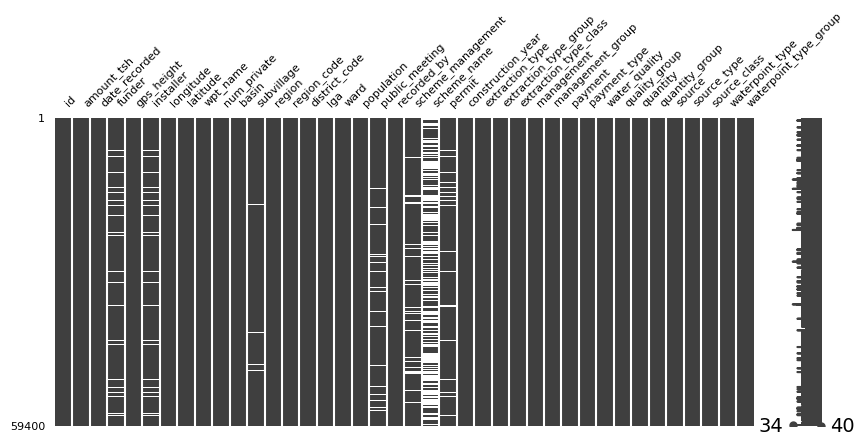

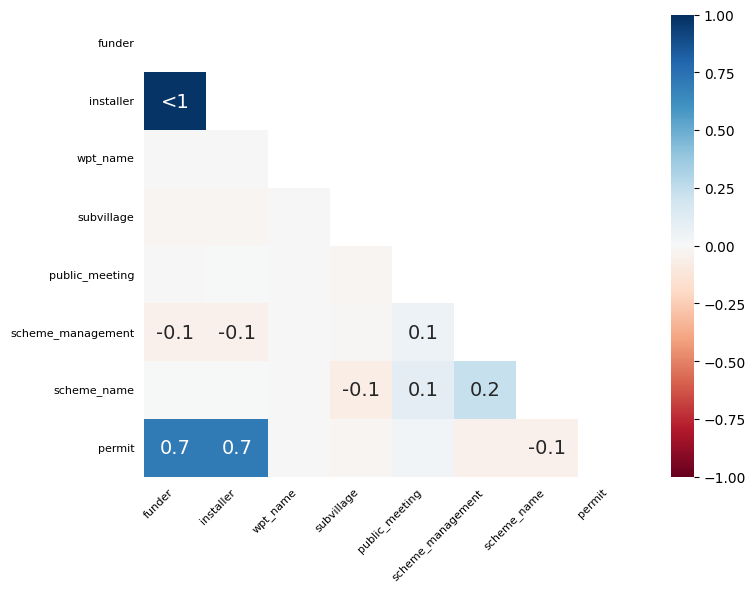

In [16]:
# Visualization
import missingno as msno
msno.matrix(pump_data, figsize=(10,4))
plt.xticks(fontsize=8)   # уменьшаем подписи по X
plt.yticks(fontsize=8)   # уменьшаем подписи по Y
plt.show()
msno.heatmap(pump_data, figsize=(8,6))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [20]:
def print_top10_per_null_column(df, top_n=10):
    # Select columns that contain at least one NaN
    null_cols = df.columns[df.isnull().any()].tolist()
    n_rows = len(df)

    for c in null_cols:
        # Count non-null values for the column
        vc = df[c].value_counts(dropna=True)

        print(f"\n===== {c} =====")  # column header

        if vc.empty:
            # Edge case: column has only NaNs
            print("No non-null values to display.")
            continue

        # Keep only top N
        vc = vc.head(top_n)

        # Percent relative to all rows (not just non-nulls)
        pct = (vc / n_rows * 100).round(2)

        # Build a compact table: value | count | percent
        out = (
            pd.DataFrame({
                "value": vc.index,
                "count": vc.values,
                "percent": pct.values
            })
        )

        # Pretty print without the dataframe index
        print(out.to_string(index=False))

# Usage
print_top10_per_null_column(pump_data, top_n=10)


===== funder =====
                 value  count  percent
Government Of Tanzania   9084    15.29
                Danida   3114     5.24
                Hesawa   2202     3.71
                 Rwssp   1374     2.31
            World Bank   1349     2.27
                  Kkkt   1287     2.17
          World Vision   1246     2.10
                Unicef   1057     1.78
                 Tasaf    877     1.48
      District Council    843     1.42

===== installer =====
             value  count  percent
               DWE  17402    29.30
        Government   1825     3.07
               RWE   1206     2.03
             Commu   1060     1.78
            DANIDA   1050     1.77
              KKKT    898     1.51
            Hesawa    840     1.41
                 0    777     1.31
              TCRS    707     1.19
Central government    622     1.05

===== wpt_name =====
          value  count  percent
           none   3563     6.00
        Shuleni   1748     2.94
       Zahanati    830   

In [33]:
# --- explicit lists ---
pump_data_imp = pump_data.copy()
bool_cols = ["permit", "public_meeting"]  # True/False only
cat_cols  = ["scheme_name", "scheme_management", "installer",
             "funder", "subvillage"]  # other categoricals

# 1) Booleans: fill NaNs with column-wise mode (most frequent)
for c in bool_cols:
    mode_val = pump_data[c].mode(dropna=True).iat[0]
    pump_data_imp[c] = pump_data_imp[c].fillna(mode_val)

# 2) Other categoricals: fill NaNs with "Unknown"
pump_data_imp[cat_cols] = pump_data_imp[cat_cols].fillna("Unknown")
pump_data_imp["wpt_name"] = pump_data_imp["wpt_name"].fillna("none")

# (Optional) quick check
print(pump_data_imp[bool_cols + cat_cols + ["wpt_name"]].isna().sum())

permit               0
public_meeting       0
scheme_name          0
scheme_management    0
installer            0
funder               0
subvillage           0
wpt_name             0
dtype: int64


/tmp/ipython-input-4055900706.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pump_data_imp[c] = pump_data_imp[c].fillna(mode_val)


In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

bool_cols = ["permit", "public_meeting"]
cat_cols  = ["scheme_name", "scheme_management", "installer", "funder", "subvillage"]

preprocessor = ColumnTransformer(
    transformers=[
        ("bool_mode",   SimpleImputer(strategy="most_frequent"),                   bool_cols),
        ("cat_unknown", SimpleImputer(strategy="constant", fill_value="Unknown"),  cat_cols),
        ("wpt_none",    SimpleImputer(strategy="constant", fill_value="none"),     ["wpt_name"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False   # <- keep original column names
).set_output(transform="pandas")

# If sklearn >= 1.2, get a pandas DataFrame back (with column names)
preprocessor.set_output(transform="pandas")

# Fit on train; then use transform on any split for reproducibility
pump_data_imputed = preprocessor.fit_transform(pump_data)

# Quick check
cols_to_check = bool_cols + cat_cols + ["wpt_name"]
#print(pump_data_imputed[cols_to_check].isna().sum())


In [31]:
print(cols_to_check)
print(type(pump_data_imputed))
print(pump_data_imputed.columns.tolist())
print(pump_data_imputed[cols_to_check].isna().sum())



['permit', 'public_meeting', 'scheme_name', 'scheme_management', 'installer', 'funder', 'subvillage', 'wpt_name']
<class 'pandas.core.frame.DataFrame'>
['permit', 'public_meeting', 'scheme_name', 'scheme_management', 'installer', 'funder', 'subvillage', 'wpt_name', 'id', 'amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude', 'num_private', 'basin', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'recorded_by', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
permit               0
public_meeting       0
scheme_name          0
scheme_management    0
installer            0
funder               0
subvillage           0
wpt_name             0
dtype: int64
